# Foi aproveitado o que o Felipe havia feito 
# [IR PARA SEÇÃO "ANALISE DUAN"]
---




In [ ]:
from __future__ import division #remova isso caso python > 3
from __future__ import print_function # remova isso caso python > 3

import pandas as pd
import numpy as np
import pylab as plt #use matplotlib para python > 3 e conda

from IPython.display import Image, display

In [3]:
caminho = "/home/duanhubcwb/DuanHUB/Aulas/ciclo_2/"
#se o inicializar o conda+jupyter pelo terminal:  colocar caminho = "" 
arquivo ="ToolDataSheetVsNQuebras.csv" #<- arquivo a ser utilizado

### Variável dependente (para predição -y-):
*Número de quebras por ano*: `nQuebras`

### Chave primária: 
*código do tipo da ferramenta*:  `PartNumber`

### Variáveis independentes:
*geometria e parâmetros da ferramenta de corte* 

1. `LargerDiameter`
2. `StemDiameter`
3. `TotalLength`
4. `ChannelLength`

In [4]:
# display(Image(caminho+"usinagem_geo.PNG"))

In [5]:
dadosB = None

try:  # carrega dos dados , o separador é ";" pois tem campos na coluna Supplier com ","
    dadosB = pd.read_csv(caminho+arquivo, sep=";")
except IOError as err:
    print (err)

In [6]:
dadosB = dadosB[dadosB.PropellerAngle <= 360] #remove os demais dados incorretos

In [7]:
dadosB.head(1)

,PartNumber,nQuebras,Family,Supplier,LargerDiameter,StemDiameter,TotalLength,ChannelLength,MaterialClass,PropellerAngle,Refrigeration
0,4721700050,5,217-RH,3M TECHNICAL CERAMICS ZWEIGNIEDERLA,3.0,3.0,38.0,2.5,Desconhecido,0.0,0


In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import math

from sklearn.preprocessing import MinMaxScaler
from itertools import combinations

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
#funções utilitárias:

def get(data, coluna): return data.loc[:,[coluna]] #pega a coluna de um conteiner do pandas e retorna um novo DataFrame

def rss(y,predicted):
    return float(((predicted - y) ** 2.0).sum())

def norm(vetor): return vetor/(vetor.max()) #normaliza caso o vetor/variavel tenha o método max()

def calc_rss(y, predicted): return rss( norm (y), norm (predicted)) #normaliza e calcular RSS

def doMatPlotText(texto, x=0.5, y=0.5, cor='red'): plt.text(x,y, texto, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor=cor, alpha=0.5))
    
def ordemZero(x, s=500): #plota o gráfico da predição interpolando os valores
    return np.linspace(
        min(x.values.ravel()),
        max(x.values.ravel()), s )[:, np.newaxis]

In [10]:
def knn_plotter(xx,yy,dataset, kernel=None, titulo=" "):
    """
    Faz a regressão indicando o objeto em kernel com uma base de dados, a coluna X e a predicao Y

    Keyword arguments:
    xx -- str: variavel independente (nome da coluna da base de dados)
    yy -- str: variavel dependente  (nome da coluna para predicao)
    dataset -- pandas.Dataframe : conjunto de dados do Pandas (requer as series xx e yy), exemplo: KNeighborsRegressor(n_neighbors=3)
    titulo -- str: titulo do grafico (suporta subplot)
    
    """
    (varXnome,varYnome) = (xx , yy)
  
    X_knn, Y_knn = ( get(dataset,varXnome), get(dataset,varYnome) )
    
    KnnModel = kernel 

    KnnModel.fit(X_knn, Y_knn )

    Yp_knn = KnnModel.predict( X_knn )
  
    Yp_knn_interpol = KnnModel.predict( ordemZero( X_knn ) ).flatten()

    knn_rss = 0.0
    
    try: #algumas classes do sklearn não retornam array, e sim uma serie de dados:
        knn_rss = calc_rss(Y_knn, Yp_knn)
    except:
        knn_rss = calc_rss(Y_knn[yy], Yp_knn)
  
    mlabel =  "rss={0:.3f}".format(knn_rss)     #colocar o rss numa legenda do plt   

    plt.plot( X_knn, Y_knn, "db", label="ori."); 
    plt.title(titulo)
    plt.plot(ordemZero( X_knn ), 
             Yp_knn_interpol, "--r", label=mlabel); 
    plt.xlabel(varXnome); plt.ylabel(varYnome);
    plt.legend(); plt.grid();
    

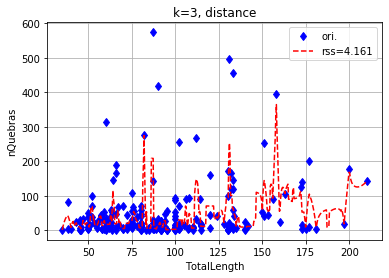

In [11]:
k=3
metodo='distance'
KnnModel = KNeighborsRegressor(n_neighbors=k,weights=metodo)
knn_plotter('TotalLength','nQuebras',dadosB, KnnModel, titulo="k={0}, {1}".format(k,metodo))

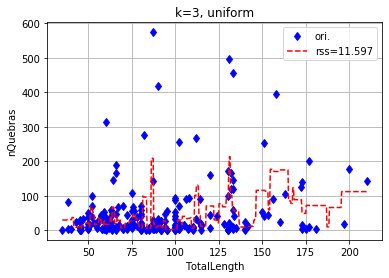

In [12]:
k=3
metodo='uniform'
KnnModel = KNeighborsRegressor(n_neighbors=k,weights=metodo)
knn_plotter('TotalLength','nQuebras',dadosB, KnnModel, titulo="k={0}, {1}".format(k,metodo))

# ANALISE DUAN - A PARTIR DAQUI!!!
---

In [34]:
def calc_rss(y,predicted):
    return float(((predicted - y) ** 2).sum())
    
def calc_r2(y,predicted):
    return r2_score(predicted,y)

def Metodos(X, y, metodo='LinearRegression', tamanho_teste=0.25, Klist=[2], weight='uniform', 
            linspace_size=500, xfig_size=18, yfig_size=18):

    # Normalizando Y
    scaler = MinMaxScaler()
    scaler.fit(y)
    y_scaled = scaler.transform(y)
    
    if type(Klist) != list or sorted(Klist)[0] < 1:
        print("'Klist' deve ser do tipo 'list', contendo apenas inteiros >= 1. Return 0.")
        return 0, 0, 0
    elif type(metodo) != str:
        print("O parametro 'metodo' deve ser do tipo 'str'. Return 0.")
        return 0, 0, 0
    
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size = tamanho_teste, shuffle=True)
    
    # todas as combinacoes de parametros possiveis
    combinacoes = []
    for i in range(1, X.shape[1]+1):
        comb = combinations(X.columns,i)
        for j in list(comb):
            combinacoes.append(list(j))
                
    if metodo == 'LinearRegression':
        reg = LinearRegression()
        r2_train, r2_test, rss_train, rss_test, atr_used = [], [], [], [], []
        
        ncols = 2
        nrows = math.ceil((X.shape[1]/ncols))
        fig, ax2d = plt.subplots(nrows,ncols, figsize=(xfig_size,yfig_size))
        fig.subplots_adjust(hspace=0.4)
        axis = np.ravel(ax2d)

        for count, i in enumerate(combinacoes):

            tempFit = reg.fit(X_train[i], y_train)
            tempX = X_test[i]
            tempPredict = tempFit.predict(tempX)
            
            if len(i) == 1:
                axis[count].scatter(X_test[i], y_test)
                axis[count].plot(tempX, tempFit.predict(tempX), color='red', linewidth=2)
                axis[count].set_title('LinearRegression: {}'.format(i))
                axis[count].legend(['Model', 'Real'])

            atr_used.append(i)
            r2_train.append(calc_r2(y_train, tempFit.predict(X_train[i])))
            r2_test.append(calc_r2(y_test, tempPredict))
            rss_train.append(calc_rss(y_train, tempFit.predict(X_train[i])))
            rss_test.append(calc_rss(y_test, tempPredict))   
            
        R = pd.DataFrame(data = np.array(atr_used), columns=['Atributo'])
        R['r2_train'] = r2_train
        R['r2_test'] = r2_test
        R['rss_train'] = rss_train
        R['rss_test'] = rss_test
        
        best_r2 = R['r2_test'].max()
        best_rss = R['rss_test'].min()
        best_atributes_r2 = combinacoes[r2_test.index(best_r2)]
        best_atributes_rss = combinacoes[rss_test.index(best_rss)]
        
        print("\n"," "*12,"MELHOR PARAMETRIZACAO - LinearRegression")
        print("+-------------------------------------------------------------------------+")
        print("  Melhor R2_test = {0}   |   Atributos: {1}".format(round(best_r2,5),best_atributes_r2))
        print("  Melhor RSS_test = {0}   |   Atributos: {1}".format(round(best_rss,5), best_atributes_rss))
        #print("  Atributos usados: {}".format(best_atributes))
        print("+-------------------------------------------------------------------------+")
        return R, best_r2, best_rss
        
    ## FALTA IMPLEMENTAR ADAPTACOES
    elif metodo ==  'KNeighborsRegressor':
        r2_train, r2_test, rss_train, rss_test, k_used, atr_used = [], [], [], [], [], []
        ncols = 2
        nrows = math.ceil((X.shape[1]/ncols)*len(Klist))
        fig, ax2d = plt.subplots(nrows,ncols, figsize=(xfig_size,yfig_size))
        fig.subplots_adjust(hspace=0.4)
        axis = np.ravel(ax2d)
        c = 0
        
        for count, i in enumerate(combinacoes):
            
            for indK, k in enumerate(Klist):
                knn = KNeighborsRegressor(n_neighbors=k, weights=weight)
                tempFit = knn.fit(X_train[i], y_train) #ok
                if len(i) == 1:
                    tempX = np.linspace(min(X_test[i].values.ravel()), max(X_test[i].values.ravel()), linspace_size)[:,np.newaxis]
                    tempPredict = tempFit.predict(tempX)
                    tempPredict = tempFit.predict(tempX)
                    axis[c].scatter(X_test[i], y_test)
                    axis[c].plot(tempX, tempPredict, color='red', linewidth=2)
                    axis[c].set_title('KNeighborsRegressor, k={}: {}'.format(k, i))
                    axis[c].legend(['Model', 'Real'])

                k_used.append(k)
                atr_used.append(i)
                r2_train.append(calc_r2(y_train, tempFit.predict(X_train[i])))
                r2_test.append(calc_r2(y_test, tempFit.predict(X_test[i])))
                rss_train.append(calc_rss(y_train, tempFit.predict(X_train[i])))
                rss_test.append(calc_rss(y_test, tempFit.predict(X_test[i])))
                c+=1    
                
        R = pd.DataFrame(data = np.array(atr_used), columns=['Atributo'])
        R['k_used']    = k_used
        R['r2_train']  = r2_train
        R['r2_test']   = r2_test
        R['rss_train'] = rss_train
        R['rss_test']  = rss_test

        best_r2 = R['r2_test'].max()
        best_rss = R['rss_test'].min()
        best_atributes_r2 = atr_used[r2_test.index(best_r2)]
        best_atributes_rss = atr_used[rss_test.index(best_rss)]

        print("\n"," "*12,"MELHOR PARAMETRIZACAO - KNeighborsRegressor")
        print("+-------------------------------------------------------------------------+")
        print("  Melhor R2_test = {0} | k={1} | Atributos: {2}".format(round(best_r2,5), k_used[r2_test.index(best_r2)],best_atributes_r2))
        print("  Melhor RSS_test = {0} | k={1} | Atributos: {2}".format(round(best_rss,5), k_used[rss_test.index(best_rss)],best_atributes_rss))
        print("+-------------------------------------------------------------------------+")
        return R, best_r2, best_rss

    # FALTA IMPLEMENTAR ADAPTACOES       
    elif metodo == 'DecisionTreeRegressor':
        
        tree = DecisionTreeRegressor()
        
        r2_train, r2_test, rss_train, rss_test, atr_used = [], [], [], [], []

        ncols = 2
        nrows = math.ceil((X.shape[1]/ncols))
        fig, ax2d = plt.subplots(nrows,ncols, figsize=(xfig_size,yfig_size))
        fig.subplots_adjust(hspace=0.4)
        axis = np.ravel(ax2d)
        
        for count, i in enumerate(combinacoes):

            tempFit = tree.fit(X_train[i], y_train)
            
            tempX = X_test[i]
            tempPredict = tempFit.predict(tempX)
            
            if len(i) == 1:
                tempX = np.linspace(min(X_test[i].values.ravel()), max(X_test[i].values.ravel()), linspace_size)[:,np.newaxis]
                tempPredict = tempFit.predict(tempX)
                axis[count].scatter(X_test[i], y_test)
                axis[count].plot(tempX, tempFit.predict(tempX), color='r', linewidth=2)
                axis[count].set_title('DecisionTreeRegressor {}'.format(i))
                axis[count].legend(['Model', 'Real'])

            atr_used.append(i)   
            r2_train.append(calc_r2(y_train, tempFit.predict(X_train[i])))
            r2_test.append(calc_r2(y_test, tempFit.predict(X_test[i])))
            rss_train.append(calc_rss(y_train, np.array(tempFit.predict(X_train[i])).reshape(-1,1)))
            rss_test.append(calc_rss(y_test, np.array(tempFit.predict(X_test[i])).reshape(-1,1)))
            
        R = pd.DataFrame(data = np.array(atr_used), columns=['Atributo'])
        R['r2_train'] = r2_train
        R['r2_test'] = r2_test
        R['rss_train'] = rss_train
        R['rss_test'] = rss_test
        
        best_r2 = R['r2_test'].max()
        best_rss = R['rss_test'].min()
        best_atributes_r2 = combinacoes[r2_test.index(best_r2)]
        best_atributes_rss = combinacoes[rss_test.index(best_rss)]
        
        print("\n"," "*13,"MELHOR PARAMETRIZACAO - DecisionTreeRegressor")
        print("+-------------------------------------------------------------------------+")
        print("  Melhor R2_test = {0} | Atributos: {1}".format(round(best_r2,5), best_atributes_r2))
        print("  Melhor RSS_test = {0} | Atributos: {1}".format(round(best_rss,5), best_atributes_rss))
        #print("  Atributos usados: {}".format(best_atributes))
        print("+-------------------------------------------------------------------------+")
        return R, best_r2, best_rss
    
    elif metodo == 0:
        print()
        return R, best_r2, best_atributes, bestMethod
    else:
        print("Metodo nao reconhecido e/ou nao cadastrado.")
        return 0, 0, 0

In [35]:
X = dadosB[['LargerDiameter','StemDiameter','TotalLength','ChannelLength']]
y = dadosB[['nQuebras']]


               MELHOR PARAMETRIZACAO - DecisionTreeRegressor
+-------------------------------------------------------------------------+
  Melhor R2_test = -0.63469 | Atributos: ['LargerDiameter', 'StemDiameter', 'TotalLength']
  Melhor RSS_test = 1.21832 | Atributos: ['StemDiameter', 'TotalLength', 'ChannelLength']
+-------------------------------------------------------------------------+


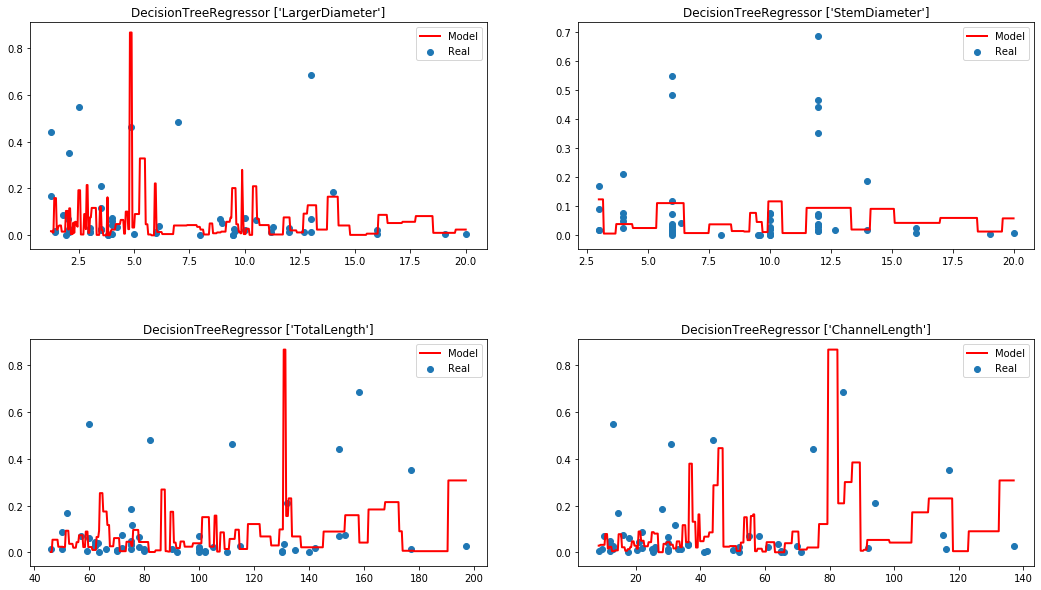

In [36]:
R_tree, best_r2_tree, best_rss_tree = Metodos(X, y, 'DecisionTreeRegressor', yfig_size=10)


              MELHOR PARAMETRIZACAO - KNeighborsRegressor
+-------------------------------------------------------------------------+
  Melhor R2_test = -0.38344 | k=3 | Atributos: ['LargerDiameter', 'TotalLength', 'ChannelLength']
  Melhor RSS_test = 0.75183 | k=4 | Atributos: ['ChannelLength']
+-------------------------------------------------------------------------+


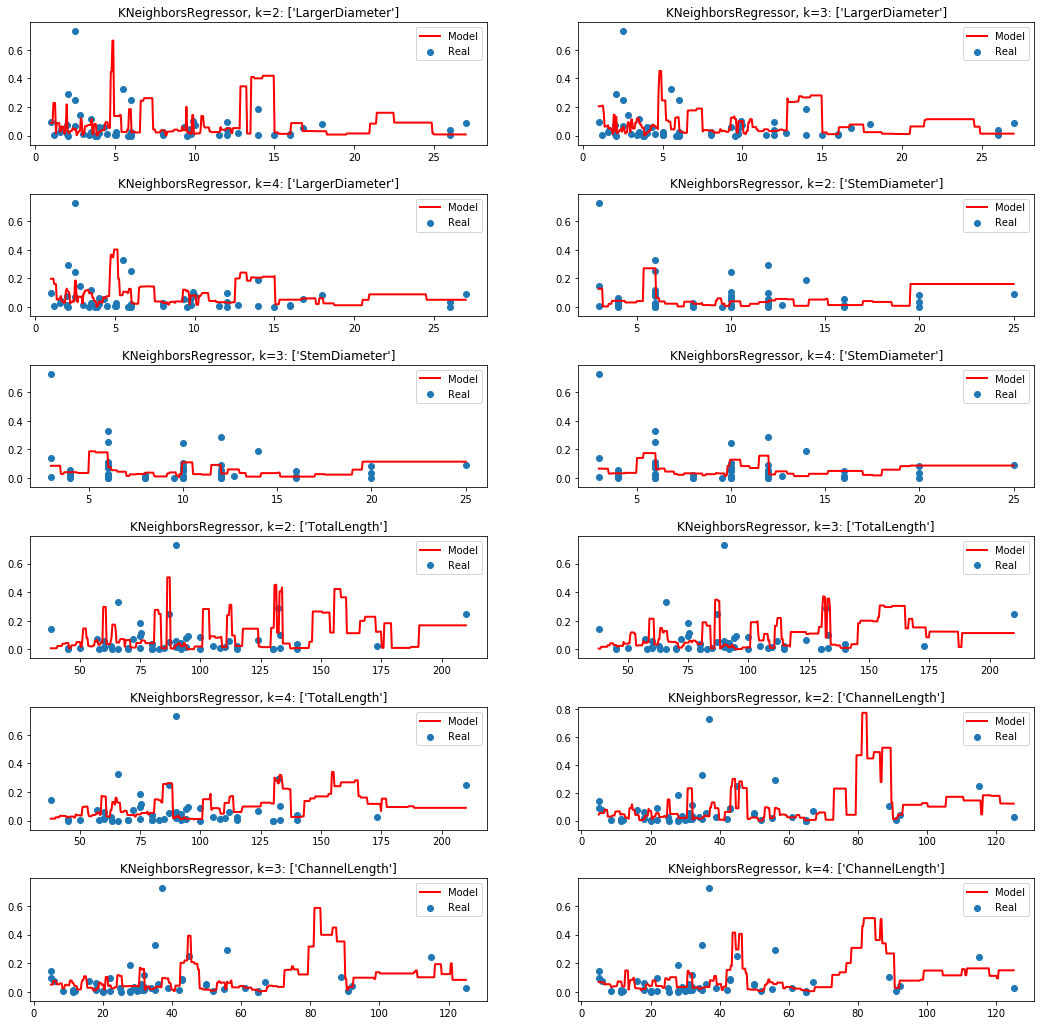

In [37]:
R_knn, best_r2_knn, best_rss_knn = Metodos(X, y, 'KNeighborsRegressor', Klist=list(range(2,5)))


              MELHOR PARAMETRIZACAO - LinearRegression
+-------------------------------------------------------------------------+
  Melhor R2_test = -24.39589   |   Atributos: ['StemDiameter', 'ChannelLength']
  Melhor RSS_test = 1.27627   |   Atributos: ['StemDiameter', 'ChannelLength']
+-------------------------------------------------------------------------+


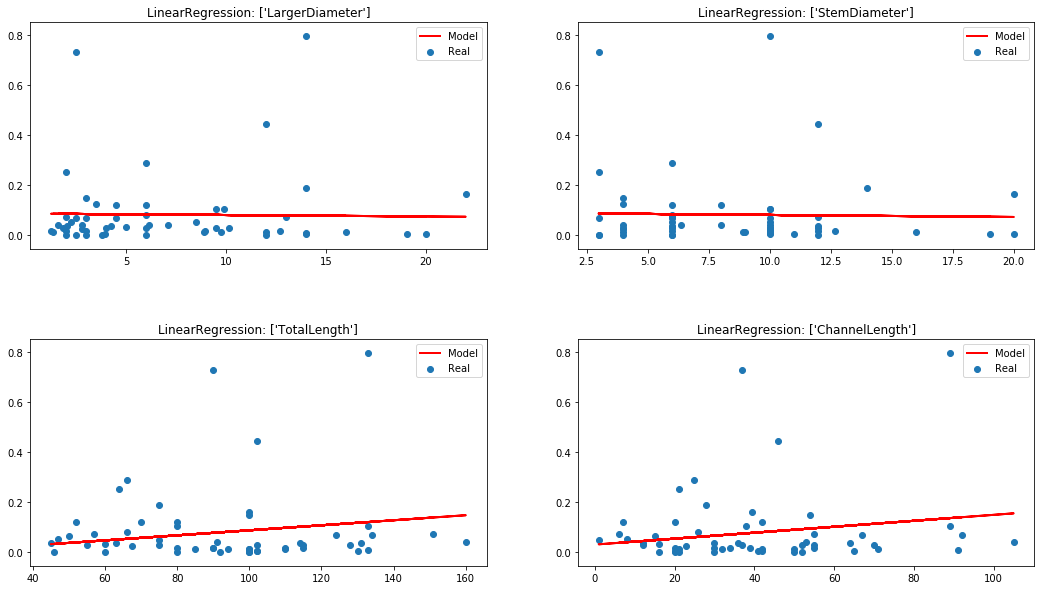

In [38]:
R_regLin, best_r2_regLin, best_rss_regLin = Metodos(X, y, 'LinearRegression', yfig_size=10)

In [39]:
R_knn

,Atributo,k_used,r2_train,r2_test,rss_train,rss_test
0,[LargerDiameter],2,-0.620394,-1.791220,3.497429,1.282387
1,[LargerDiameter],3,-1.724455,-2.596706,3.294274,1.129633
2,[LargerDiameter],4,-2.384245,-1.698972,3.396148,1.177529
3,[StemDiameter],2,-2.016557,-1.260099,5.315700,1.234934
4,[StemDiameter],3,-6.529880,-4.326805,4.046419,0.912818
5,[StemDiameter],4,-6.078339,-4.671669,3.959920,0.985257
6,[TotalLength],2,-0.241130,-0.864608,3.286533,1.606220
7,[TotalLength],3,-1.035844,-1.478483,3.067823,1.230041
8,[TotalLength],4,-1.873400,-1.928849,3.190094,1.060507
9,[ChannelLength],2,-0.165586,-1.629672,2.242575,1.149339
